# Explore Microbe Community
> Gati Aher, SUM2021

To download notebook as pdf, follow: https://towardsdatascience.com/jupyter-notebook-to-pdf-in-a-few-lines-3c48d68a7a63

In [1]:
import skbio
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

## Set Up Consistent Styling

*Key:*
- Shape indicates current carbon source
- Color indicates carbon series
- Marker Edge Width indicates day
- Marker Color indicates transfer series

In [2]:
map_carbon_shapes = {
    "C0C": "o",
    "C": "o",
    "G": "s",
    "M": "^",
}

def_marker_size = 10

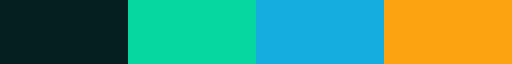

In [3]:
def_color = "#041F1E"
def_line_color = "#707070"

colors = [
    "#041F1E", # original community 
    "#06D6A0", # cellulose
    "#15ADE0", # glucose
    "#FCA311", # malate
]
map_carbon_colors = {
    "C0C": colors[0],
    "C": colors[1],
    "G": colors[2],
    "M": colors[3],
}
cmap = ListedColormap(colors, name="carbon")
cmap

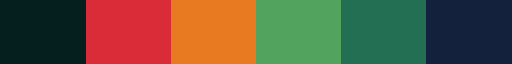

In [4]:
map_days_widths = {
    "C0C": 0,
    "3": 1,
    "5": 2,
    "7": 3,
    "10": 4,
    "20": 5,
}

colors_days = [
    "#041F1E", # C0C
    "#DA2C38", # 3
    "#E87B21", # 5
    "#52A35D", # 7
    "#226F54", # 10
    "#14213d", # 20
]

map_days_colors = {
    "C0C": colors_days[0], 
    "3": colors_days[1],
    "5": colors_days[2],
    "7": colors_days[3],
    "10": colors_days[4],
    "20": colors_days[5],
}

cmap_days = ListedColormap(colors_days, name="days")
cmap_days

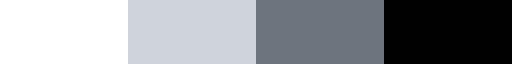

In [5]:
colors_transfers = [
    "#FFFFFF", # C0
    "#ced4da", # 1
    "#6c757d", # 2
    "#000000", # 3
]

map_transfers_colors = {
    "C0C": colors_transfers[0],
    "1": colors_transfers[1],
    "2": colors_transfers[2],
    "3": colors_transfers[3],
}

cmap_transfers = ListedColormap(colors_transfers, name="transfers")
cmap_transfers

## Import Files

* `data/processed/FCF_annotations_corrected.csv`
    * metadata for samples
* `data/processed/FCF_absolute_counts.csv`
    * OTU counts per OTU by sample
* `data/processed/FCF_relative_counts.csv`
    * OTU count percentages per OTU by sample
* `data/processed/newick_tree_from_pairwise_distances.txt`
    * phylogenetic weights on OTUs 
* `data/processed/taxonomy_table.csv`
    * map of OTU to taxonomies

In [6]:
# import phylogenetic weights
from skbio import TreeNode
tree_file = open("data/processed/newick_tree_from_pairwise_distances.txt", "r")
tree = TreeNode.read(tree_file)
tree_rooted = tree.root_at_midpoint()
print(str(tree_rooted)[:50], "...")

((OTU_124:0.52877,(OTU_154:0.601554,OTU_112:0.5779 ...


In [26]:
# import tables
df_annotations = pd.read_csv("data/processed/FCF_annotations_corrected.csv", index_col=0)
df_counts_rel = pd.read_csv("data/processed/FCF_relative_counts.csv", index_col=0)
df_counts_rel_master = pd.read_csv("data/processed/FCF_relative_counts_master.csv", index_col=0)
df_taxonomy_table = pd.read_csv("data/processed/taxonomy_table.csv", index_col=0)

In [27]:
df_taxonomy_table.head()

16rRNA
otu name                                                   
OTU_1     eu528231.1 seasonal dynamics mudflat mouth maj...
OTU_2     uncultured opitutus sp. ;k__bacteria;p__verruc...
OTU_3     rhodopseudomonas palustris ;k__bacteria;p__pro...
OTU_4     ay297802.1 waterlogged archaeological wood clo...
OTU_5     rhodoblastus acidophilus ;k__bacteria;p__prote...

In [28]:
df_annotations.head()

group series carbon transfer  day
C0C    C0C    C0C    C0C      C0C  C0C
1C3A    1C      C      C        1    3
1C3B    1C      C      C        1    3
1G3A    1G      G      G        1    3
1G3B    1G      G      G        1    3

In [29]:
df_counts_rel.head()

OTU_1     OTU_2     OTU_3     OTU_4     OTU_5     OTU_6     OTU_7  \
C0C   0.000068  0.199079  0.035956  0.059488  0.043217  0.108310  0.020763   
1C3A  0.000153  0.253979  0.042089  0.048931  0.015653  0.183539  0.190478   
1C3B  0.000111  0.277887  0.038229  0.039616  0.011167  0.158547  0.229002   
1G3A  0.000190  0.092192  0.032838  0.275816  0.009514  0.217830  0.182170   
1G3B  0.000244  0.059906  0.028979  0.252949  0.010255  0.238298  0.227637   

         OTU_8     OTU_9    OTU_10  ...   OTU_634  OTU_635   OTU_636  OTU_637  \
C0C   0.021705  0.003642  0.015079  ...  0.000057      0.0  0.000000      0.0   
1C3A  0.010907  0.003913  0.003997  ...  0.000014      0.0  0.000042      0.0   
1C3B  0.014416  0.003036  0.007280  ...  0.000026      0.0  0.000017      0.0   
1G3A  0.008944  0.001920  0.001359  ...  0.000019      0.0  0.000105      0.0   
1G3B  0.005046  0.002760  0.004911  ...  0.000000      0.0  0.000108      0.0   

      OTU_638   OTU_639   OTU_640   OTU_641  OTU_642  OTU_643  
C0C       0.0  0.000011  0.048448  0.000000      0.0      0.0  
1C3A      0.0  0.000000  0.036941  0.000000      0.0      0.0  
1C3B      0.0  0.000000  0.031102  0.000000      0.0      0.0  
1G3A      0.0  0.000000  0.031592  0.000010      0.0      0.0  
1G3B      0.0  0.000000  0.022025  0.000054      0.0      0.0  

[5 rows x 643 columns]

In [30]:
df_counts_rel_master.head()

opitutus spp.  paludibacter propionicigenes  magnetospirillum sp.  \
C0C        0.207679                      0.186666              0.111385   
1C3A       0.266982                      0.056341              0.189617   
1C3B       0.290483                      0.052058              0.163242   
1C5A       0.194116                      0.023516              0.294575   
1C5B       0.187870                      0.048505              0.132180   

      rhodopseudomonas palustris  acetobacter spp.  bacteroides spp.  \
C0C                     0.105280          0.074635          0.072615   
1C3A                    0.127545          0.012517          0.026242   
1C3B                    0.117690          0.011864          0.026510   
1C5A                    0.097889          0.008608          0.018172   
1C5B                    0.130451          0.011160          0.036059   

      pleomorphomonas oryzae  afipia sp.  rhodoblastus acidophilus  \
C0C                 0.061371    0.051296                  0.044397   
1C3A                0.050610    0.038828                  0.016139   
1C3B                0.041061    0.032812                  0.011541   
1C5A                0.031574    0.027592                  0.024460   
1C5B                0.049378    0.037942                  0.025061   

      spirochaeta spp.  ...  bosea spp.  corynebacterium durum  \
C0C           0.022216  ...         0.0               0.000000   
1C3A          0.003566  ...         0.0               0.000000   
1C3B          0.001880  ...         0.0               0.000000   
1C5A          0.003168  ...         0.0               0.000000   
1C5B          0.004889  ...         0.0               0.000008   

      rubrivivax gelatinosus  anaerococcus hydrogenalis  globicatella spp.  \
C0C                 0.000000                        0.0                0.0   
1C3A                0.000000                        0.0                0.0   
1C3B                0.000009                        0.0                0.0   
1C5A                0.000012                        0.0                0.0   
1C5B                0.000000                        0.0                0.0   

      finegoldia magna  dietzia spp.  granulicatella elegans  \
C0C                0.0           0.0                     0.0   
1C3A               0.0           0.0                     0.0   
1C3B               0.0           0.0                     0.0   
1C5A               0.0           0.0                     0.0   
1C5B               0.0           0.0                     0.0   

      actinomyces marimammalium  veillonella dispar  
C0C                         0.0                 0.0  
1C3A                        0.0                 0.0  
1C3B                        0.0                 0.0  
1C5A                        0.0                 0.0  
1C5B                        0.0                 0.0  

[5 rows x 153 columns]

## Statistical Analysis

### Alpha Diversity Analysis

Measures who is there  
1.) richness of species distribution  
2.) eveness of species distribution  

In [11]:
from skbio.diversity import alpha_diversity

In [32]:
# alpha diversity relative abundance counts need to be ints
df_counts_int = pd.DataFrame()
for col in df_counts_rel.columns.values:
    df_counts_int[col] = (100 * df_counts_rel[col]).astype('int64')
df_counts_int.head()

OTU_1  OTU_2  OTU_3  OTU_4  OTU_5  OTU_6  OTU_7  OTU_8  OTU_9  OTU_10  \
C0C       0     19      3      5      4     10      2      2      0       1   
1C3A      0     25      4      4      1     18     19      1      0       0   
1C3B      0     27      3      3      1     15     22      1      0       0   
1G3A      0      9      3     27      0     21     18      0      0       0   
1G3B      0      5      2     25      1     23     22      0      0       0   

      ...  OTU_634  OTU_635  OTU_636  OTU_637  OTU_638  OTU_639  OTU_640  \
C0C   ...        0        0        0        0        0        0        4   
1C3A  ...        0        0        0        0        0        0        3   
1C3B  ...        0        0        0        0        0        0        3   
1G3A  ...        0        0        0        0        0        0        3   
1G3B  ...        0        0        0        0        0        0        2   

      OTU_641  OTU_642  OTU_643  
C0C         0        0        0  
1C3A        0        0        0  
1C3B        0        0        0  
1G3A        0        0        0  
1G3B        0        0        0  

[5 rows x 643 columns]

In [33]:
df_alpha_diversity = pd.DataFrame()
df_alpha_diversity["ace"] = alpha_diversity(metric="ace", counts=df_counts_int.values, ids=df_counts_int.index, validate=True)
df_alpha_diversity["chao1"] = alpha_diversity(metric="chao1", counts=df_counts_int.values, ids=df_counts_int.index, validate=True)
df_alpha_diversity["chao1_ci"] = alpha_diversity(metric="chao1_ci", counts=df_counts_int.values, ids=df_counts_int.index, validate=True)
df_alpha_diversity["shannon"] = alpha_diversity(metric="shannon", counts=df_counts_int.values, ids=df_counts_int.index, validate=True)
df_alpha_diversity["simpson"] = alpha_diversity(metric="simpson", counts=df_counts_int.values, ids=df_counts_int.index, validate=True)
df_alpha_diversity["simpson_e"] = alpha_diversity(metric="simpson_e", counts=df_counts_int.values, ids=df_counts_int.index, validate=True)

In [34]:
df_alpha_diversity["faith_pd"] = alpha_diversity(metric="faith_pd", counts=df_counts_int.values, ids=df_counts_int.index, tree=tree_rooted, otu_ids=[n.name for n in tree.tips()], validate=True)

In [50]:
# add groupings
df_alpha_diversity["group"] = df_annotations["group"]
order = ["C0C", "1C", "2C", "1G", "2G", "3G", "1M", "2M", "3M"]
df_alpha_diversity.head()

ace  chao1                                  chao1_ci   shannon  \
C0C   14.397470   14.0                                  (14, 14)  3.333583   
1C3A  15.371237   18.0   (12.946782268400106, 50.02352578997235)  2.836613   
1C3B  15.755102   18.0   (12.946782268400106, 50.02352578997235)  2.760918   
1G3A   9.606414    9.0                                    (9, 9)  2.559112   
1G3B  13.253142   12.0  (11.093649057398883, 21.678164071002378)  2.600520   

       simpson  simpson_e  faith_pd group  
C0C   0.872506   0.560252  0.760955   C0C  
1C3A  0.819593   0.461920  0.747149    1C  
1C3B  0.805201   0.427792  0.747149    1C  
1G3A  0.791839   0.533774  0.689418    1G  
1G3B  0.789136   0.431126  0.742762    1G

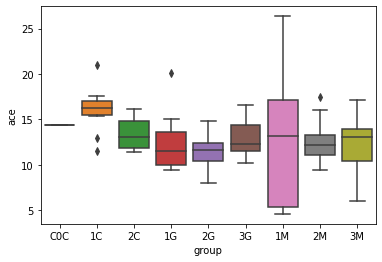

In [38]:
ax = sns.boxplot(x="group", y="ace", data=df_alpha_diversity, order=order)

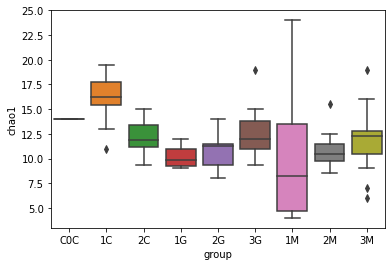

In [39]:
ax = sns.boxplot(x="group", y="chao1", data=df_alpha_diversity, order=order)

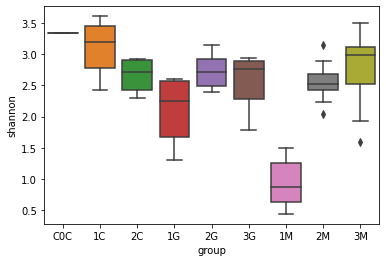

In [40]:
ax = sns.boxplot(x="group", y="shannon", data=df_alpha_diversity, order=order)

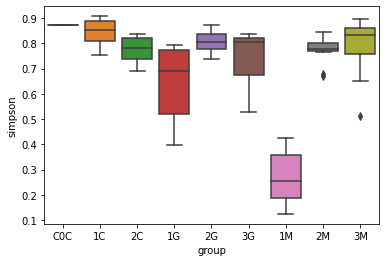

In [41]:
ax = sns.boxplot(x="group", y="simpson", data=df_alpha_diversity, order=order)

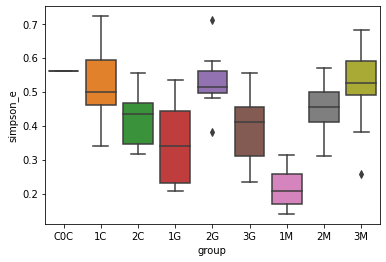

In [42]:
ax = sns.boxplot(x="group", y="simpson_e", data=df_alpha_diversity, order=order)

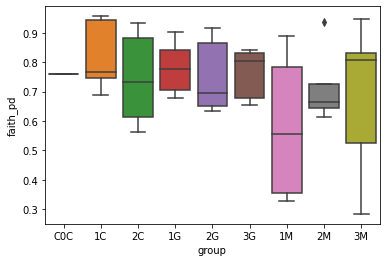

In [43]:
ax = sns.boxplot(x="group", y="faith_pd", data=df_alpha_diversity, order=order)

In [44]:
df_alpha_diversity.to_csv("results/alpha_diversity.csv")
print("df_alpha_diversity.shape", df_alpha_diversity.shape)

df_alpha_diversity.shape (86, 8)


### Alpha Diversity on Relative Counts Master

In [45]:
# alpha diversity relative abundance counts need to be ints
df_counts_int = pd.DataFrame()
for col in df_counts_rel_master.columns.values:
    df_counts_int[col] = (100 * df_counts_rel_master[col]).astype('int64')
df_counts_int.head()

opitutus spp.  paludibacter propionicigenes  magnetospirillum sp.  \
C0C              20                            18                    11   
1C3A             26                             5                    18   
1C3B             29                             5                    16   
1C5A             19                             2                    29   
1C5B             18                             4                    13   

      rhodopseudomonas palustris  acetobacter spp.  bacteroides spp.  \
C0C                           10                 7                 7   
1C3A                          12                 1                 2   
1C3B                          11                 1                 2   
1C5A                           9                 0                 1   
1C5B                          13                 1                 3   

      pleomorphomonas oryzae  afipia sp.  rhodoblastus acidophilus  \
C0C                        6           5                         4   
1C3A                       5           3                         1   
1C3B                       4           3                         1   
1C5A                       3           2                         2   
1C5B                       4           3                         2   

      spirochaeta spp.  ...  bosea spp.  corynebacterium durum  \
C0C                  2  ...           0                      0   
1C3A                 0  ...           0                      0   
1C3B                 0  ...           0                      0   
1C5A                 0  ...           0                      0   
1C5B                 0  ...           0                      0   

      rubrivivax gelatinosus  anaerococcus hydrogenalis  globicatella spp.  \
C0C                        0                          0                  0   
1C3A                       0                          0                  0   
1C3B                       0                          0                  0   
1C5A                       0                          0                  0   
1C5B                       0                          0                  0   

      finegoldia magna  dietzia spp.  granulicatella elegans  \
C0C                  0             0                       0   
1C3A                 0             0                       0   
1C3B                 0             0                       0   
1C5A                 0             0                       0   
1C5B                 0             0                       0   

      actinomyces marimammalium  veillonella dispar  
C0C                           0                   0  
1C3A                          0                   0  
1C3B                          0                   0  
1C5A                          0                   0  
1C5B                          0                   0  

[5 rows x 153 columns]

In [47]:
df_alpha_diversity_master = pd.DataFrame()
df_alpha_diversity_master["ace"] = alpha_diversity(metric="ace", counts=df_counts_int.values, ids=df_counts_int.index, validate=True)
df_alpha_diversity_master["chao1"] = alpha_diversity(metric="chao1", counts=df_counts_int.values, ids=df_counts_int.index, validate=True)
df_alpha_diversity_master["chao1_ci"] = alpha_diversity(metric="chao1_ci", counts=df_counts_int.values, ids=df_counts_int.index, validate=True)
df_alpha_diversity_master["shannon"] = alpha_diversity(metric="shannon", counts=df_counts_int.values, ids=df_counts_int.index, validate=True)
df_alpha_diversity_master["simpson"] = alpha_diversity(metric="simpson", counts=df_counts_int.values, ids=df_counts_int.index, validate=True)
df_alpha_diversity_master["simpson_e"] = alpha_diversity(metric="simpson_e", counts=df_counts_int.values, ids=df_counts_int.index, validate=True)

In [51]:
# add groupings
df_alpha_diversity_master["group"] = df_annotations["group"]
order = ["C0C", "1C", "2C", "1G", "2G", "3G", "1M", "2M", "3M"]
df_alpha_diversity_master.head()

ace  chao1                                  chao1_ci   shannon  \
C0C   12.381413   12.0                                  (12, 12)  3.193002   
1C3A  11.253333   10.5  (10.030262059763976, 18.261169330502646)  2.708623   
1C3B  11.183673   10.5  (10.030262059763976, 18.261169330502646)  2.646001   
1C5A  10.707648   10.0                                  (10, 10)  2.658492   
1C5B  14.255102   13.5  (13.030262059763976, 21.261169330502646)  3.194048   

       simpson  simpson_e group  
C0C   0.869465   0.638397   C0C  
1C3A  0.814509   0.539108    1C  
1C3B  0.801041   0.502617    1C  
1C5A  0.801749   0.504410    1C  
1C5B  0.867528   0.580675    1C

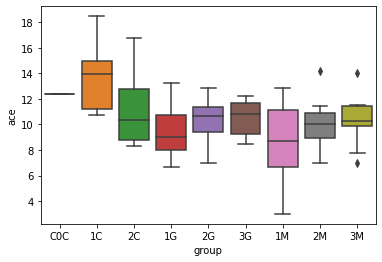

In [52]:
ax = sns.boxplot(x="group", y="ace", data=df_alpha_diversity_master, order=order)

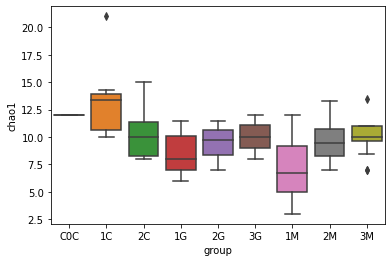

In [53]:
ax = sns.boxplot(x="group", y="chao1", data=df_alpha_diversity_master, order=order)

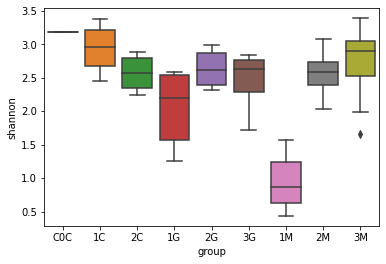

In [54]:
ax = sns.boxplot(x="group", y="shannon", data=df_alpha_diversity_master, order=order)

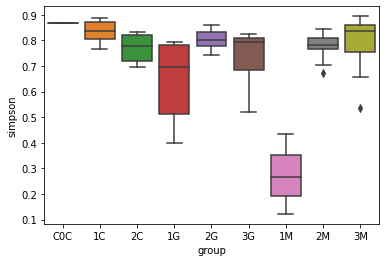

In [55]:
ax = sns.boxplot(x="group", y="simpson", data=df_alpha_diversity_master, order=order)

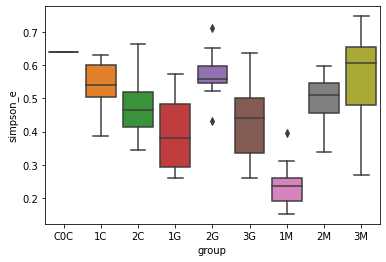

In [56]:
ax = sns.boxplot(x="group", y="simpson_e", data=df_alpha_diversity_master, order=order)

### Visualize Composition Distribution

In [57]:
groups = list(set(df_annotations["group"].to_list()))
groups.sort()
groups

['1C', '1G', '1M', '2C', '2G', '2M', '3G', '3M', 'C0C']

In [31]:
def rel_count_stem(df_counts_rel, df_annotations, groupstring, is_log=False):
    f, ax = plt.subplots(figsize=(6, 20))
    for sample_label in df_counts_rel.index:
        if sample_label.startswith(groupstring):
            data = df_counts_rel.loc[sample_label]
            # set plot variables
            series_style = map_carbon_colors[df_annotations.loc[sample_label, "series"]]
            carbon_style = map_carbon_shapes[df_annotations.loc[sample_label, "carbon"]]
            day_style = map_days_widths[df_annotations.loc[sample_label, "day"]]
            transfer_style = map_transfers_colors[df_annotations.loc[sample_label, "transfer"]]    
            # set plot styling
            if is_log:
                bottom = -6
            else:
                bottom = 0
            (markerline, stemlines, baseline) = ax.stem(data.index, data.values, orientation="horizontal", bottom=bottom)
            plt.setp(markerline, markersize=10, color=series_style, marker=carbon_style, markeredgecolor=transfer_style, markeredgewidth=day_style)
            plt.setp(stemlines, "color", def_line_color)
            plt.setp(baseline, "color", def_line_color)
            if not is_log: plt.xlim([0, 1])
    
    ax.set_title("{}: Relative Counts".format(groupstring))
    if is_log:
        ax.set_xlabel("Log Transform Relative Counts")
    else: 
        ax.set_xlabel("Relative Counts")

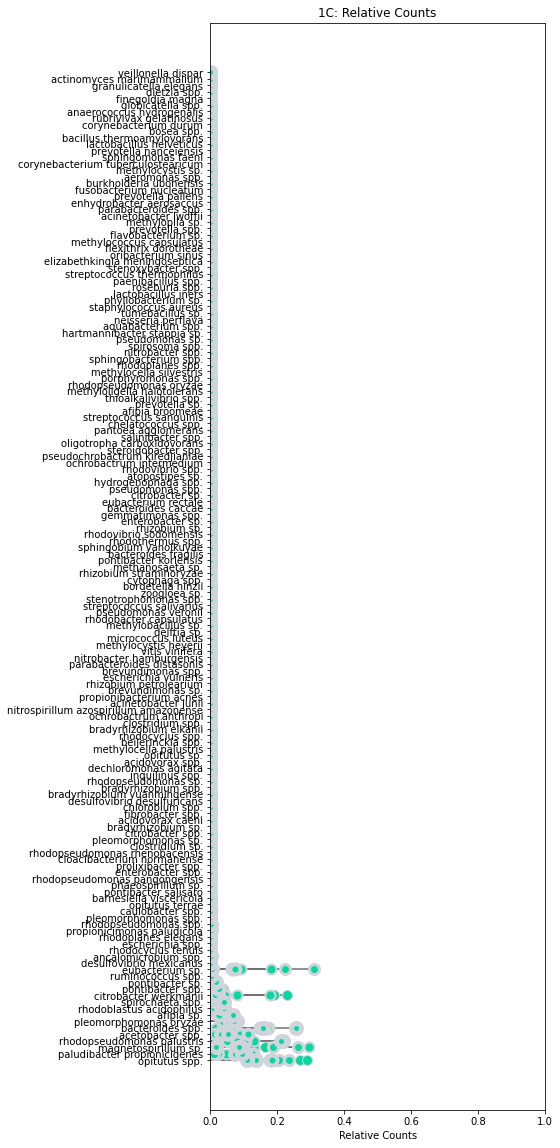

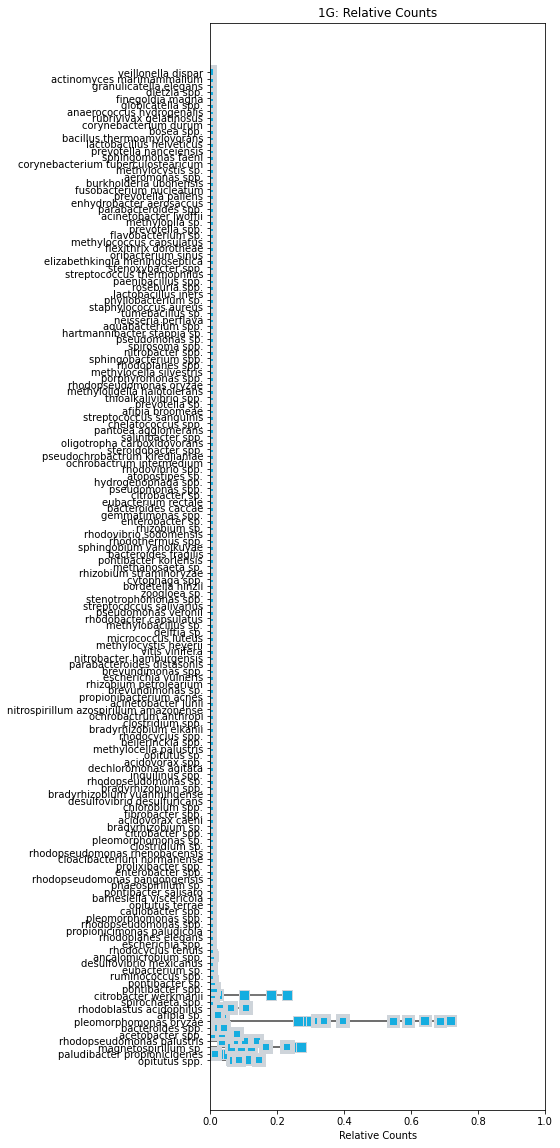

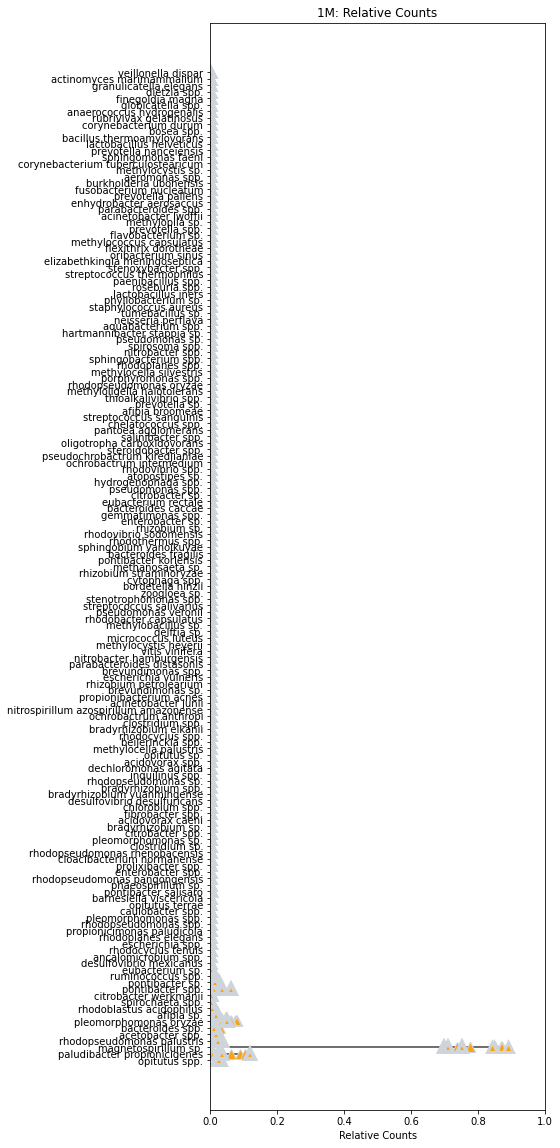

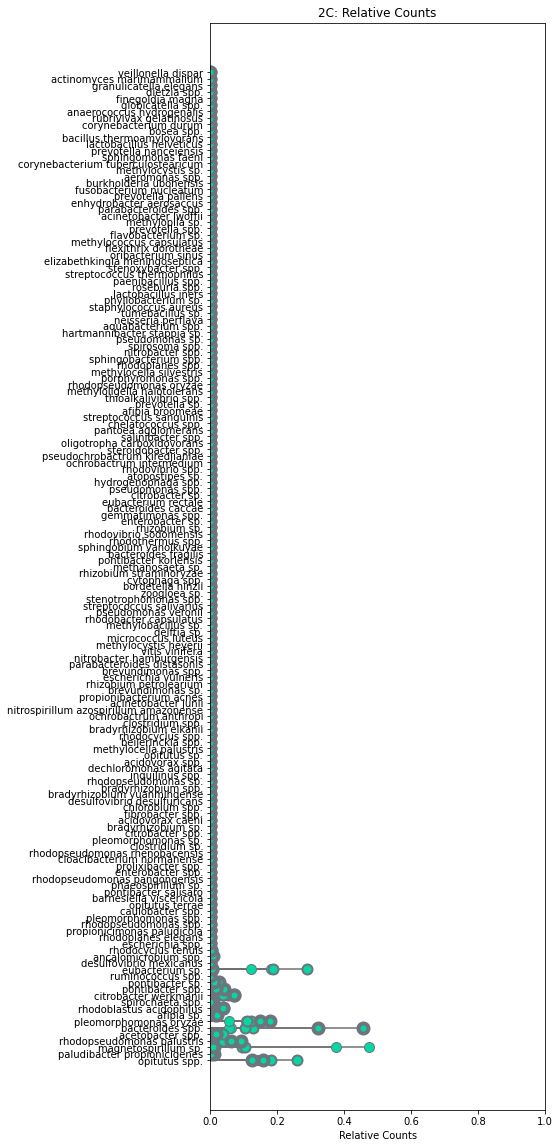

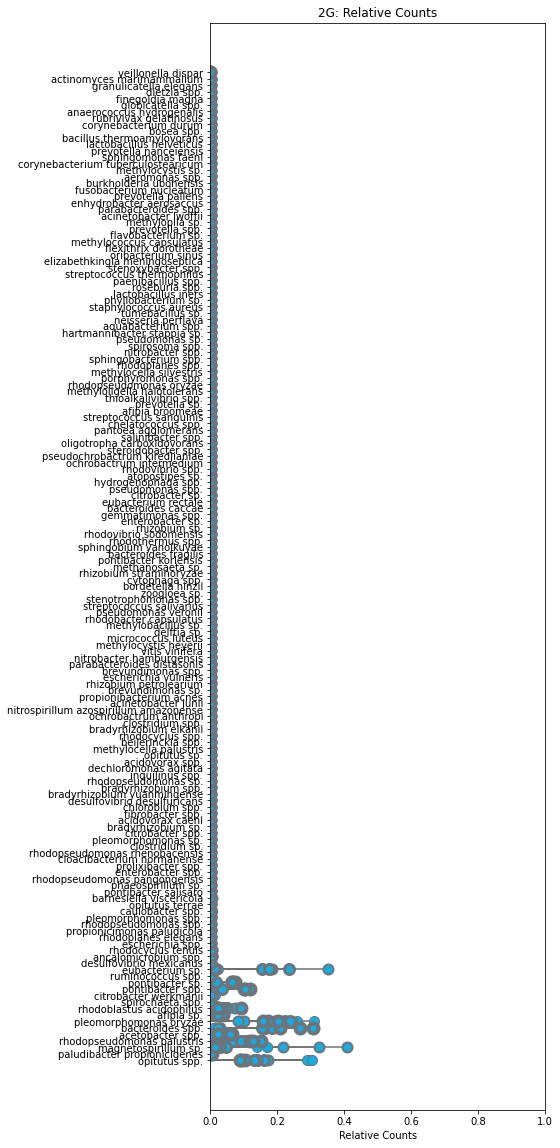

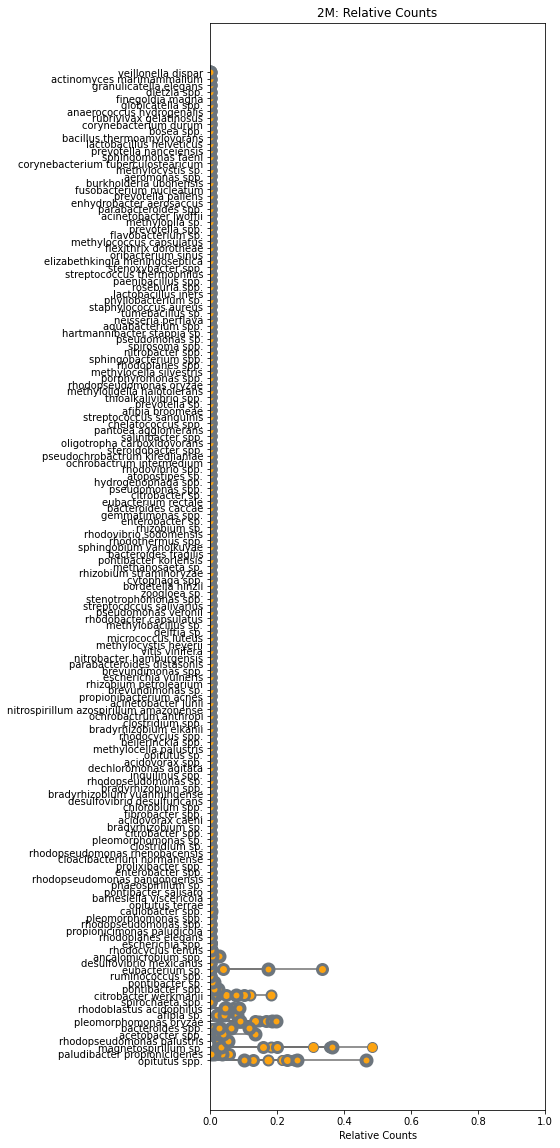

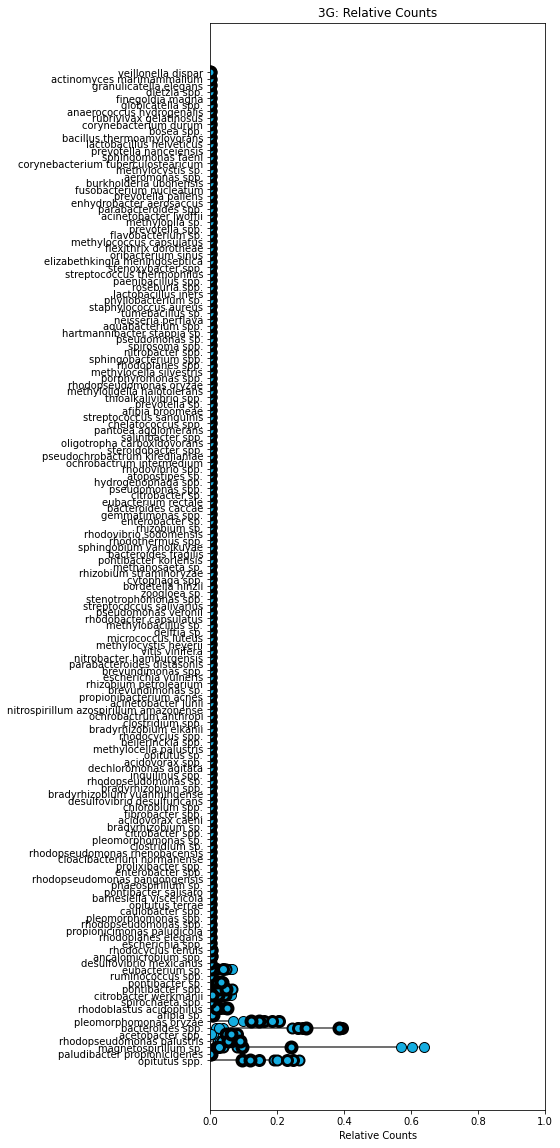

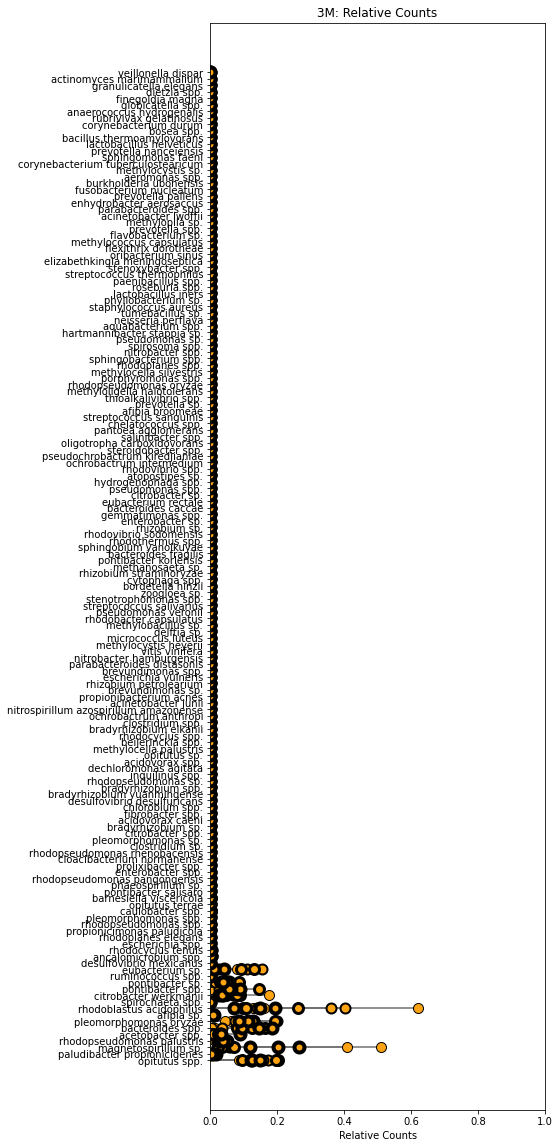

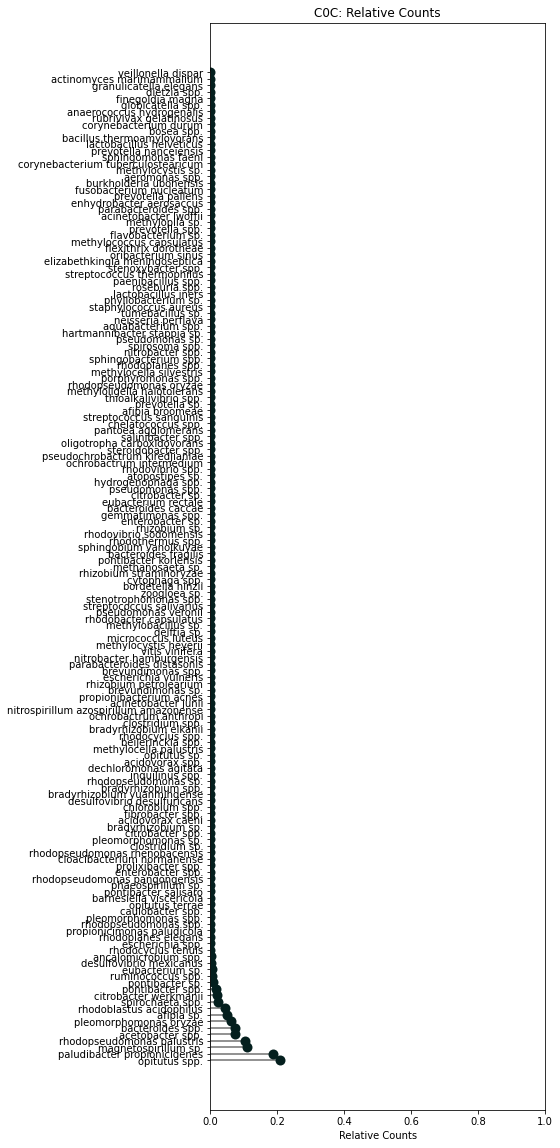

In [74]:
for g in groups:
    rel_count_stem(df_counts_rel, df_annotations, g)

### Beta-Diversity: PCoA with Bray-Curtis Distance
Mesaure differences between samples  
* compute Bray-Curtis distances, a beta diversity distance metric, between all pairs of samples
* perform principal coordinates analysis (PCoA) on the distance matrix
* see how the groups fall (color by factor)

Use Bray-Curtis dissimilarity because it is a better measure of the distance between populations. It is calculated by dividing shared abundance by total abundance. For ANOSIM statistical analysis, a positive value of r statistic indicates clustering, and the p-value is significant at an alpha of 0.1.

Ordination techniques, such as PCoA, are useful for exploratory analysis. The next step is to quantify the strength of the grouping/clustering that we see in ordination plots. There are many statistical methods available to accomplish this; many operate on distance matrices. Let’s use ANOSIM to quantify the strength of the clustering we see in the ordination plots above, using the Bray-Curtis distance matrix and sample metadata.

From the PCoA plots, we can see the clustering of carbon source glucose and carbon source malate. There is also an interesting trend where the left side of the cellulose cluster is from smaller days, and the right side of the cellulose cluster is from larger days, maybe indicating the presence of a transition growth state.

*Sources:*  
scikit-bio tutorial

In [60]:
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
from skbio.stats.distance import anosim

In [61]:
def plot_styled_pcoa(bc_pc, df_annotations, sample_list, title="PCoA", day_mode=False):
    f, ax = plt.subplots(figsize=(10, 10))
    for sample_label in sample_list:
        data = bc_pc.samples.loc[sample_label]
        # set plot variables
        if day_mode:
            # colored and annotated by days after transfer 
            # set plot variables
            carbon_style = map_carbon_shapes[df_annotations.loc[sample_label, "carbon"]]
            day_style = map_days_colors[df_annotations.loc[sample_label, "day"]]
            transfer_style = map_transfers_colors[df_annotations.loc[sample_label, "transfer"]]    
            # set plot styling
            plotline = ax.plot(data["PC1"], data["PC2"])
            plt.setp(plotline, markersize=15, color="white", marker=carbon_style, markeredgecolor=transfer_style, markeredgewidth=0)
            ax.annotate(df_annotations.loc[sample_label, "day"], (data["PC1"], data["PC2"]), color=day_style)
        else:
            series_style = map_carbon_colors[df_annotations.loc[sample_label, "series"]]
            carbon_style = map_carbon_shapes[df_annotations.loc[sample_label, "carbon"]]
            day_style = map_days_widths[df_annotations.loc[sample_label, "day"]]
            transfer_style = map_transfers_colors[df_annotations.loc[sample_label, "transfer"]]    
            # set plot styling
            plotline = ax.plot(data["PC1"], data["PC2"])
            plt.setp(plotline, markersize=15, color=series_style, marker=carbon_style, markeredgecolor=transfer_style, markeredgewidth=day_style)
    ax.set_title(title)
    ax.set_xlabel(f"PC 1 ({round(100 * bc_pc.eigvals[0] / bc_pc.eigvals.sum(), 2)}% explained variance)")
    ax.set_ylabel(f"PC 2 ({round(100 * bc_pc.eigvals[1] / bc_pc.eigvals.sum(), 2)}% explained variance)")

#### All Samples

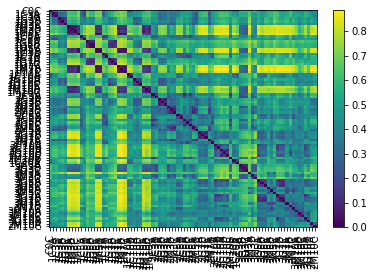

In [62]:
bc_dm = beta_diversity("braycurtis", df_counts_rel.values, df_counts_rel.index)
bc_dm

In [63]:
bc_pc = pcoa(bc_dm)
bc_pc_cum_sum = bc_pc.eigvals / bc_pc.eigvals.sum()

num_comp = 2
print(num_comp, "Components Cummulative Explained Variance:", sum(bc_pc_cum_sum[0:num_comp]))
num_comp = 3
print(num_comp, "Components Cummulative Explained Variance:", sum(bc_pc_cum_sum[0:num_comp]))

2 Components Cummulative Explained Variance: 0.5445734984632676
3 Components Cummulative Explained Variance: 0.6479356631959429


/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.16693396018042822 and the largest is 5.71187969820123.
  warn(


In [64]:
bc_pc.samples

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
C0C    0.101422  0.028255  0.034533 -0.285063  0.000010  0.167526 -0.077624   
1C3A  -0.007975 -0.012810  0.178605 -0.291340 -0.094741 -0.003580  0.051853   
1C3B   0.013354 -0.020052  0.193052 -0.300226 -0.101755 -0.003808  0.040570   
1G3A  -0.023560 -0.218325  0.086115 -0.080071 -0.050527 -0.071473  0.163109   
1G3B  -0.071991 -0.213595  0.076349 -0.093745 -0.061872 -0.083185  0.178349   
...         ...       ...       ...       ...       ...       ...       ...   
3M10C  0.076806  0.139632 -0.034489  0.071192 -0.096376  0.089132  0.087818   
3G10A  0.219350  0.007094 -0.232673 -0.001498  0.002975 -0.036412  0.014684   
3G10B  0.065285  0.059267 -0.220264 -0.007310  0.033251 -0.103657  0.053321   
2M10A  0.239451 -0.022924  0.044867 -0.116526 -0.126553  0.013766 -0.125631   
2M10C  0.230885 -0.065222  0.121701 -0.075640 -0.145010 -0.120449 -0.132929   

            PC8       PC9      PC10  ...  PC77  PC78  PC79  PC80  PC81  PC82  \
C0C    0.049604  0.091750  0.028756  ...   0.0   0.0   0.0   0.0   0.0   0.0   
1C3A  -0.013348 -0.074265  0.023575  ...   0.0   0.0   0.0   0.0   0.0   0.0   
1C3B  -0.033073 -0.093492  0.005620  ...   0.0   0.0   0.0   0.0   0.0   0.0   
1G3A  -0.066516 -0.032661  0.012358  ...   0.0   0.0   0.0   0.0   0.0   0.0   
1G3B  -0.087714 -0.020862 -0.000815  ...   0.0   0.0   0.0   0.0   0.0   0.0   
...         ...       ...       ...  ...   ...   ...   ...   ...   ...   ...   
3M10C  0.061619  0.045680  0.099174  ...   0.0   0.0   0.0   0.0   0.0   0.0   
3G10A -0.015110 -0.022237  0.134710  ...   0.0   0.0   0.0   0.0   0.0   0.0   
3G10B  0.010275  0.038790  0.139817  ...   0.0   0.0   0.0   0.0   0.0   0.0   
2M10A  0.088769  0.165166 -0.092855  ...   0.0   0.0   0.0   0.0   0.0   0.0   
2M10C  0.004906 -0.018977 -0.110967  ...   0.0   0.0   0.0   0.0   0.0   0.0   

       PC83  PC84  PC85  PC86  
C0C     0.0   0.0   0.0   0.0  
1C3A    0.0   0.0   0.0   0.0  
1C3B    0.0   0.0   0.0   0.0  
1G3A    0.0   0.0   0.0   0.0  
1G3B    0.0   0.0   0.0   0.0  
...     ...   ...   ...   ...  
3M10C   0.0   0.0   0.0   0.0  
3G10A   0.0   0.0   0.0   0.0  
3G10B   0.0   0.0   0.0   0.0  
2M10A   0.0   0.0   0.0   0.0  
2M10C   0.0   0.0   0.0   0.0  

[86 rows x 86 columns]

In [65]:
results = anosim(bc_dm, df_annotations, column='group', permutations=999)
print("group clustering", results['test statistic'])
print("\t p-value", results['p-value'])

results = anosim(bc_dm, df_annotations, column='carbon', permutations=999)
print("carbon clustering", results['test statistic'])
print("\t p-value", results['p-value'])

results = anosim(bc_dm, df_annotations, column='series', permutations=999)
print("series clustering", results['test statistic'])
print("\t p-value", results['p-value'])

results = anosim(bc_dm, df_annotations, column='transfer', permutations=999)
print("transfer clustering", results['test statistic'])
print("\t p-value", results['p-value'])

results = anosim(bc_dm, df_annotations, column='day', permutations=999)
print("day clustering", results['test statistic'])
print("\t p-value", results['p-value'])                                                                                                                                

group clustering 0.6530821697821225
	 p-value 0.001
carbon clustering 0.5871836602475986
	 p-value 0.001
series clustering 0.2415716938045938
	 p-value 0.001
transfer clustering 0.17218866063375535
	 p-value 0.001
day clustering 0.13138682373293242
	 p-value 0.001


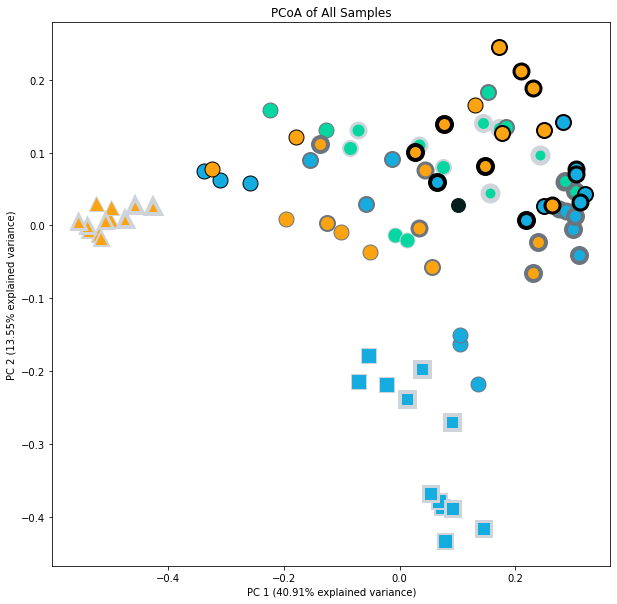

In [66]:
plot_styled_pcoa(bc_pc, df_annotations, df_counts_rel.index, title="PCoA of All Samples")

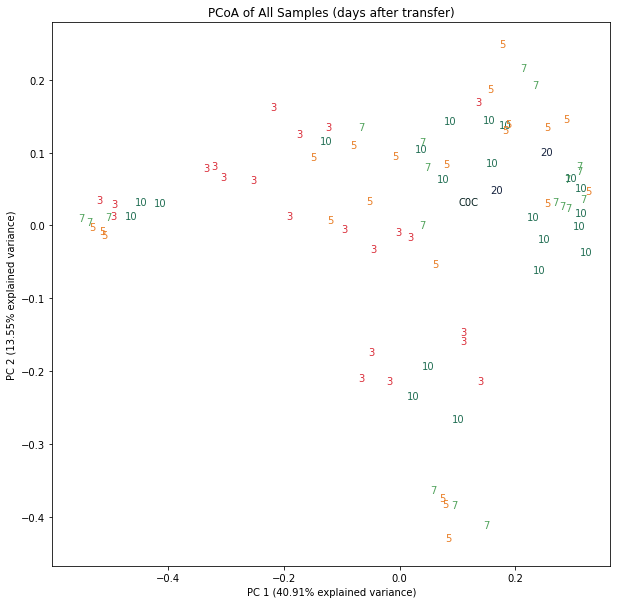

In [67]:
plot_styled_pcoa(bc_pc, df_annotations, df_counts_rel.index, title="PCoA of All Samples (days after transfer)", day_mode=True)

## Make PCoA Plots of Only Samples Currently on Carbon Source Cellulose

Groups: 'C0C', '1C', '2C', '2G', '2M', '3G','3M'

In [68]:
is_C_carbon = df_annotations["carbon"].isin(['C0C', 'C'])
df_counts_rel_only_C_carbon = df_counts_rel[is_C_carbon]
print(len(df_counts_rel_only_C_carbon.index), df_counts_rel_only_C_carbon.index)
    
bc_dm_only_C_carbon = beta_diversity("braycurtis", df_counts_rel_only_C_carbon.values, df_counts_rel_only_C_carbon.index)
bc_pc_only_C_carbon = pcoa(bc_dm_only_C_carbon)

# clustering analysis
results = anosim(bc_dm_only_C_carbon, df_annotations, column='group', permutations=999)
print("group clustering", results['test statistic'])
print("\t p-value", results['p-value'])

# results = anosim(bc_dm_only_C_carbon, df_annotations, column='carbon', permutations=999)
# print("carbon clustering", results['test statistic'])
# print("\t p-value", results['p-value'])

results = anosim(bc_dm_only_C_carbon, df_annotations, column='series', permutations=999)
print("series clustering", results['test statistic'])
print("\t p-value", results['p-value'])

results = anosim(bc_dm_only_C_carbon, df_annotations, column='transfer', permutations=999)
print("transfer clustering", results['test statistic'])
print("\t p-value", results['p-value'])

results = anosim(bc_dm_only_C_carbon, df_annotations, column='day', permutations=999)
print("day clustering", results['test statistic'])
print("\t p-value", results['p-value'])

62 Index(['C0C', '1C3A', '1C3B', '1C5A', '1C5B', '1C7A', '1C7B', '1C10A', '1C10B',
       '2C3A', '2C3B', '2G3A', '2G3B', '2G3C', '2M3A', '2M3B', '2M3C', '2C5A',
       '2C5B', '2G5A', '2G5B', '2G5C', '2M5A', '2M5B', '2G7A', '2G7B', '2G7C',
       '2M7A', '2M7B', '2C10A', '2C10B', '2G10A', '2G10B', '2G10C', '2M10B',
       '1C20B', '1C20A', '3G3A', '3G3B', '3G3C', '3M3A', '3M3B', '3M3C',
       '3G5A', '3G5B', '3G5C', '3M5A', '3M5B', '3M5C', '3G7A', '3G7B', '3G7C',
       '3M7A', '3M7B', '3M7C', '3M10A', '3M10B', '3M10C', '3G10A', '3G10B',
       '2M10A', '2M10C'],
      dtype='object')
group clustering 0.3540397680056884
	 p-value 0.001
series clustering 0.23712674374926027
	 p-value 0.001


/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.147129471337178 and the largest is 2.560180312965344.
  warn(


transfer clustering 0.1871283512309153
	 p-value 0.001
day clustering 0.2870270466461432
	 p-value 0.001


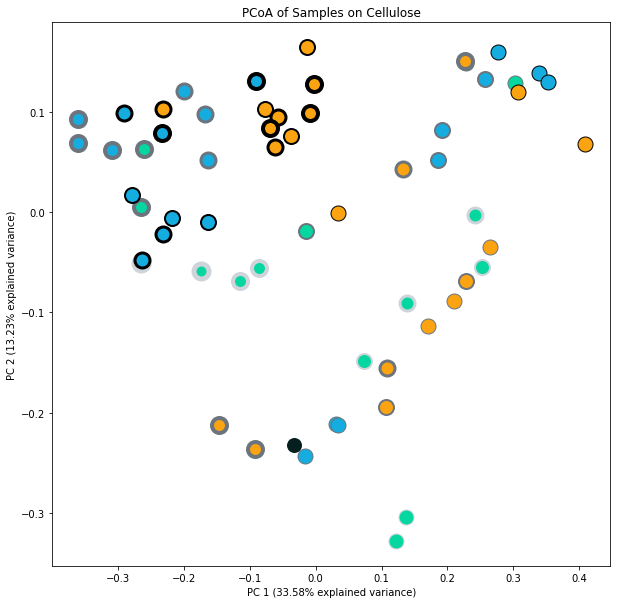

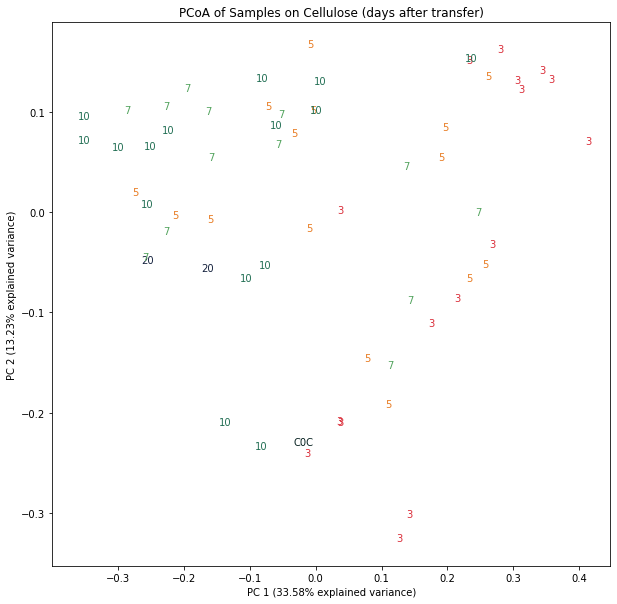

In [69]:
plot_styled_pcoa(bc_pc_only_C_carbon, df_annotations, df_counts_rel_only_C_carbon.index, title="PCoA of Samples on Cellulose")
plot_styled_pcoa(bc_pc_only_C_carbon, df_annotations, df_counts_rel_only_C_carbon.index, title="PCoA of Samples on Cellulose (days after transfer)", day_mode=True)

## Make PCoA Plots of Cellulose Series

Series: 'C0C', 'C'

In [70]:
is_C_series = df_annotations["series"].isin(['C0C', 'C'])
df_counts_rel_only_C_series = df_counts_rel[is_C_series]
print(len(df_counts_rel_only_C_series.index), df_counts_rel_only_C_series.index)
    
bc_dm_only_C_series = beta_diversity("braycurtis", df_counts_rel_only_C_series.values, df_counts_rel_only_C_series.index)
bc_pc_only_C_series = pcoa(bc_dm_only_C_series)

# clustering analysis
results = anosim(bc_dm_only_C_series, df_annotations, column='group', permutations=999)
print("group clustering", results['test statistic'])
print("\t p-value", results['p-value'])

# results = anosim(bc_dm_only_C_carbon, df_annotations, column='carbon', permutations=999)
# print("carbon clustering", results['test statistic'])
# print("\t p-value", results['p-value'])

# results = anosim(bc_dm_only_C_series, df_annotations, column='series', permutations=999)
# print("series clustering", results['test statistic'])
# print("\t p-value", results['p-value'])

results = anosim(bc_dm_only_C_series, df_annotations, column='transfer', permutations=999)
print("transfer clustering", results['test statistic'])
print("\t p-value", results['p-value'])

results = anosim(bc_dm_only_C_series, df_annotations, column='day', permutations=999)
print("day clustering", results['test statistic'])
print("\t p-value", results['p-value'])

17 Index(['C0C', '1C3A', '1C3B', '1C5A', '1C5B', '1C7A', '1C7B', '1C10A', '1C10B',
       '2C3A', '2C3B', '2C5A', '2C5B', '2C10A', '2C10B', '1C20B', '1C20A'],
      dtype='object')
group clustering 0.25614035087719306
	 p-value 0.019
transfer clustering 0.25614035087719306
	 p-value 0.025
day clustering 0.34396551724137936
	 p-value 0.017


/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.024596976691838558 and the largest is 0.6663102982898365.
  warn(


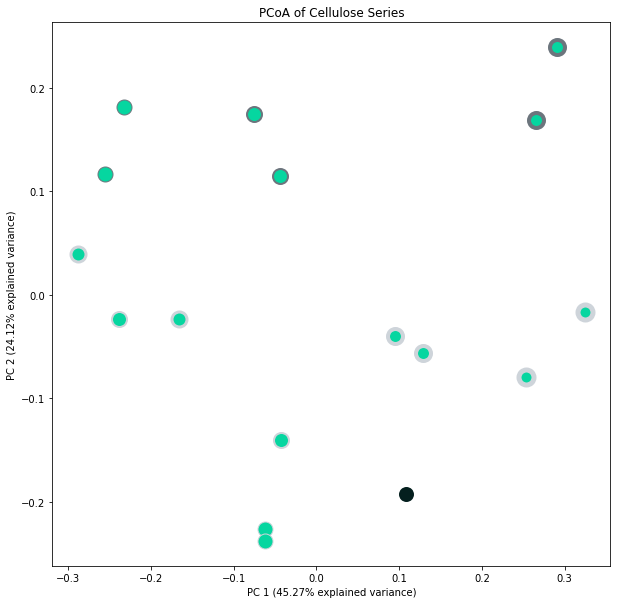

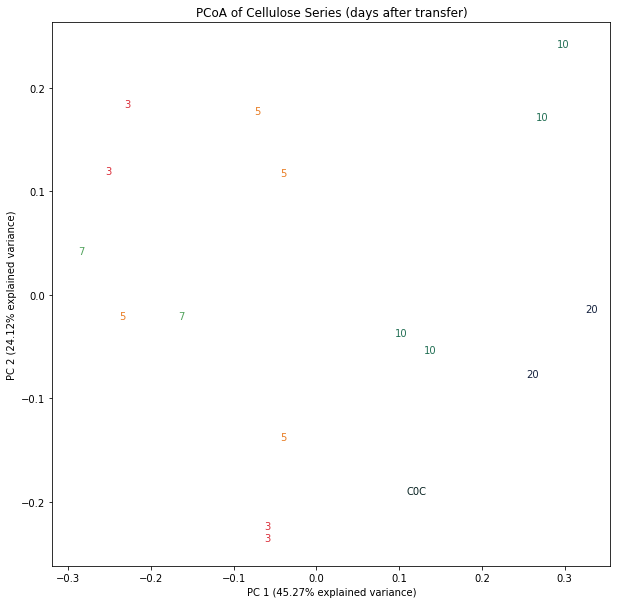

In [71]:
plot_styled_pcoa(bc_pc_only_C_series, df_annotations, df_counts_rel_only_C_series.index, title="PCoA of Cellulose Series")
plot_styled_pcoa(bc_pc_only_C_series, df_annotations, df_counts_rel_only_C_series.index, title="PCoA of Cellulose Series (days after transfer)", day_mode=True)

## Make PCoA Plots of Glucose Series

Groups: 'C0C', '1G', '2G', '3G'

In [72]:
is_G_series = df_annotations["series"].isin(['C0C', 'G'])
df_counts_rel_only_G_series = df_counts_rel[is_G_series]
print(len(df_counts_rel_only_G_series.index), df_counts_rel_only_G_series.index)
    
bc_dm_only_G_series = beta_diversity("braycurtis", df_counts_rel_only_G_series.values, df_counts_rel_only_G_series.index)
bc_pc_only_G_series = pcoa(bc_dm_only_G_series)

# clustering analysis
results = anosim(bc_dm_only_G_series, df_annotations, column='group', permutations=999)
print("group clustering", results['test statistic'])
print("\t p-value", results['p-value'])

results = anosim(bc_dm_only_G_series, df_annotations, column='carbon', permutations=999)
print("carbon clustering", results['test statistic'])
print("\t p-value", results['p-value'])

# results = anosim(bc_dm_only_G_series, df_annotations, column='series', permutations=999)
# print("series clustering", results['test statistic'])
# print("\t p-value", results['p-value'])

results = anosim(bc_dm_only_G_series, df_annotations, column='transfer', permutations=999)
print("transfer clustering", results['test statistic'])
print("\t p-value", results['p-value'])

results = anosim(bc_dm_only_G_series, df_annotations, column='day', permutations=999)
print("day clustering", results['test statistic'])
print("\t p-value", results['p-value'])

36 Index(['C0C', '1G3A', '1G3B', '1G3C', '1G5A', '1G5B', '1G5C', '1G7A', '1G7B',
       '1G7C', '1G10A', '1G10B', '1G10C', '2G3A', '2G3B', '2G3C', '2G5A',
       '2G5B', '2G5C', '2G7A', '2G7B', '2G7C', '2G10A', '2G10B', '2G10C',
       '3G3A', '3G3B', '3G3C', '3G5A', '3G5B', '3G5C', '3G7A', '3G7B', '3G7C',
       '3G10A', '3G10B'],
      dtype='object')
group clustering 0.5052208447507877
	 p-value 0.001
carbon clustering 0.4736163049723312
	 p-value 0.001
transfer clustering 0.5052208447507877
	 p-value 0.001


/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.08392030022906752 and the largest is 1.5546494427182163.
  warn(


day clustering 0.20388783043581804
	 p-value 0.004


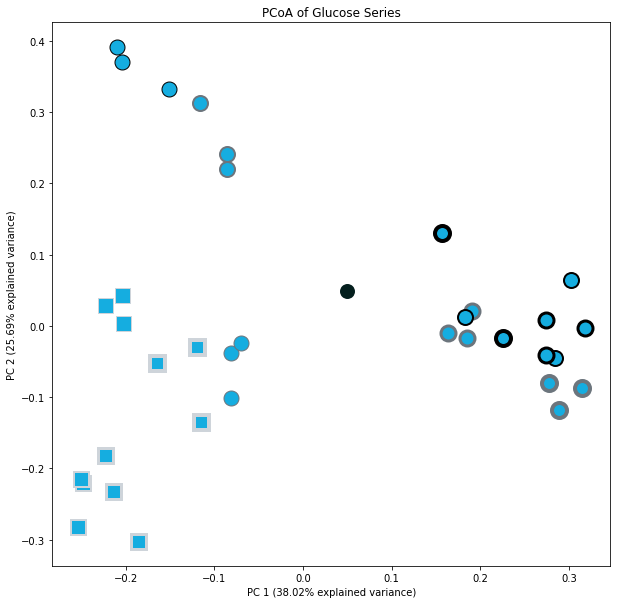

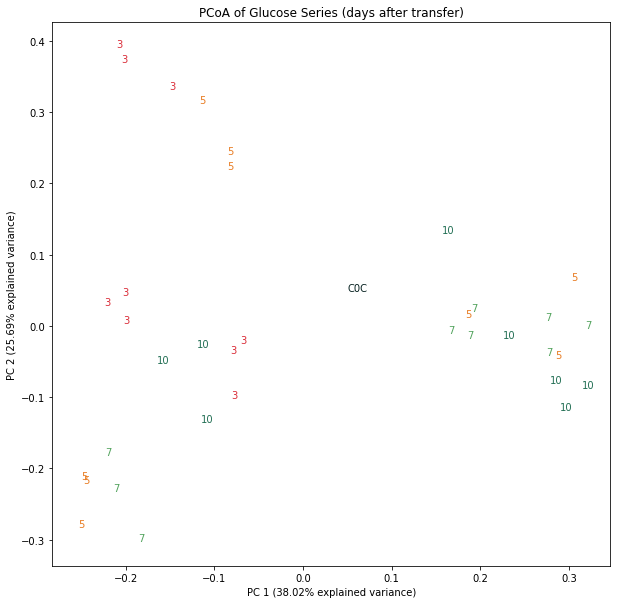

In [73]:
plot_styled_pcoa(bc_pc_only_G_series, df_annotations, df_counts_rel_only_G_series.index, title="PCoA of Glucose Series")
plot_styled_pcoa(bc_pc_only_G_series, df_annotations, df_counts_rel_only_G_series.index, title="PCoA of Glucose Series (days after transfer)", day_mode=True)

## Make PCoA Plots of Malate Series

Groups: 'C0C', '1M', '2M', '3M'

In [74]:
is_M_series = df_annotations["series"].isin(['C0C', 'M'])
df_counts_rel_only_M_series = df_counts_rel[is_M_series]
print(len(df_counts_rel_only_M_series.index), df_counts_rel_only_M_series.index)
    
bc_dm_only_M_series = beta_diversity("braycurtis", df_counts_rel_only_M_series.values, df_counts_rel_only_M_series.index)
bc_pc_only_M_series = pcoa(bc_dm_only_M_series)

# clustering analysis
results = anosim(bc_dm_only_M_series, df_annotations, column='group', permutations=999)
print("group clustering", results['test statistic'])
print("\t p-value", results['p-value'])

results = anosim(bc_dm_only_M_series, df_annotations, column='carbon', permutations=999)
print("carbon clustering", results['test statistic'])
print("\t p-value", results['p-value'])

# results = anosim(bc_dm_only_M_series, df_annotations, column='series', permutations=999)
# print("series clustering", results['test statistic'])
# print("\t p-value", results['p-value'])

results = anosim(bc_dm_only_M_series, df_annotations, column='transfer', permutations=999)
print("transfer clustering", results['test statistic'])
print("\t p-value", results['p-value'])

results = anosim(bc_dm_only_M_series, df_annotations, column='day', permutations=999)
print("day clustering", results['test statistic'])
print("\t p-value", results['p-value'])

35 Index(['C0C', '1M3A', '1M3B', '1M3C', '1M5C', '1M5A', '1M5B', '1M7A', '1M7B',
       '1M7C', '1M10A', '1M10B', '1M10C', '2M3A', '2M3B', '2M3C', '2M5A',
       '2M5B', '2M7A', '2M7B', '2M10B', '3M3A', '3M3B', '3M3C', '3M5A', '3M5B',
       '3M5C', '3M7A', '3M7B', '3M7C', '3M10A', '3M10B', '3M10C', '2M10A',
       '2M10C'],
      dtype='object')
group clustering 0.8233990214364881
	 p-value 0.001
carbon clustering 0.8087361308837818
	 p-value 0.001
transfer clustering 0.8233990214364881
	 p-value 0.001


/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.07653544424422878 and the largest is 3.4543998179603674.
  warn(


day clustering -0.0032454496788007978
	 p-value 0.449


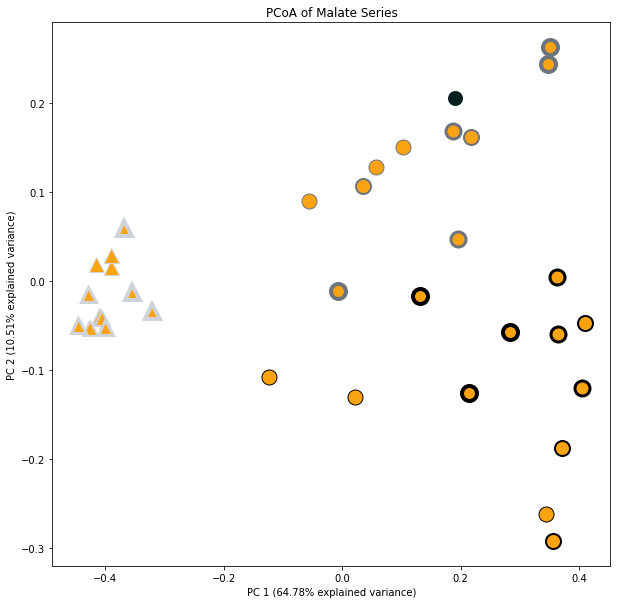

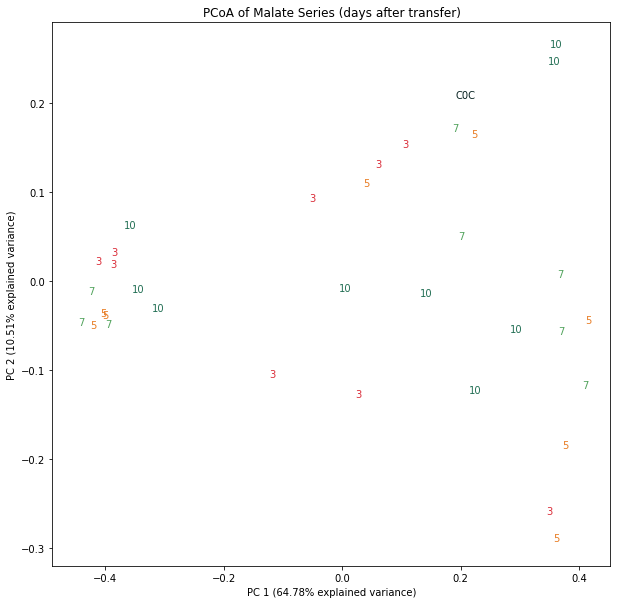

In [75]:
plot_styled_pcoa(bc_pc_only_M_series, df_annotations, df_counts_rel_only_M_series.index, title="PCoA of Malate Series")
plot_styled_pcoa(bc_pc_only_M_series, df_annotations, df_counts_rel_only_M_series.index, title="PCoA of Malate Series (days after transfer)", day_mode=True)